### Useful Functions

In [ ]:
def get_model( temp ):
    '''
    Function opens Phoenix file of specified temperature in 100 Kelvin increments from 2300 to 12000 Kelvin.
    Parameters
    ----------
    temp: str
        Desired temperature in 100K increments from 2300 to 12,000 Kelvin
        
    Returns
    -------
    wavelength: array
        Associated wavelengths for flux measurements from Phoenix FITS file, in Angstroms
        
    flux: array
        Flux measurements from Phoenix FITS file, in erg/s/cm^2
        
    temp: str
        See Parameters
    '''
    model_file = 'Med_Res_10K_Grid/lte0' + temp + '-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
    #what are the numbers here? -4.50-0.0
    hdulist = fits.open(model_file)
    flux = hdulist[0].data
    wavelength = np.exp(hdulist[0].header[('CRVAL1')]+hdulist[0].header[('CDELT1')]*np.arange(0,212027))/(10**4)
    return wavelength,flux

In [ ]:
def getMag_hires(band,wavelength,flux):
    #PHOENIX flux is erg/s/cm^2/cm
    
    import numpy as np
    import scipy.interpolate as interp
    
    wavelength= wavelength*1.0E4 #convert input wavelength to Angstroms
    flux=flux*1.0E-8 #convert input flux to ergs/cm^2/s/Angstrom
    
    '''if band=='Ks':
        bandwav,bandpass=np.loadtxt("../DATA/Ks_2MASS.txt",unpack=True)    # micron
        center=2.159
        F0= 4.283E-14        # W cm^-2 micron^-1

    elif band=='H':
        bandwav,bandpass=np.loadtxt("../DATA/H_2MASS.txt",unpack=True)
        center=1.662
        F0= 1.133E-13
    
    elif band=='J':
        bandwav,bandpass=numpy.loadtxt("../DATA/J_2MASS.txt",unpack=True)
        center=1.235
        F0= 3.129E-13'''
    
    #All filters are in Angstroms
    #code was written when: Units of Ks, H and J filters are microns, all other filters in Angstroms
    
    
    if band=='Ks':
        bandwav,bandpass=np.loadtxt('filters/k_filter.txt',unpack=True)
        center=2.159*1.0E4        #Angstroms
        F0=4.283E-14        #KsHJUBVRI F0 have units W cm^-2 micron^-1
   
    elif band=='H':
        bandwav,bandpass=np.loadtxt('filters/h_filter.txt',unpack=True)
        center=1.662*1.0E4
        F0=1.133E-13

    elif band=='J':
        bandwav,bandpass=np.loadtxt('filters/j_filter.txt',unpack=True)
        center=1.235*1.0E4
        F0=3.129E-13

    elif band=='U':
        bandwav,bandpass=np.loadtxt('filters/bessell_U.dat',unpack=True)
        center=0.365*1.0E4
        F0=4.19E-12

    elif band=='B':
        bandwav,bandpass=np.loadtxt('filters/bessell_B.dat',unpack=True)
        center=0.445*1.0E4
        F0=6.60E-12

    elif band=='V':
        bandwav,bandpass=np.loadtxt('filters/bessell_V.dat',unpack=True)
        center=0.551*1.0E4
        F0=3.61E-12

    elif band=='R':
        bandwav,bandpass=np.loadtxt('filters/bessell_R.dat',unpack=True)
        center=0.658*1.0E4
        F0=2.25E-12

    elif band=='I':
        bandwav,bandpass=np.loadtxt('filters/bessell_I.dat',unpack=True)
        center=0.806*1.0E4
        F0=1.22E-12
                                      #SDSS centers/widths/F0 from http://www.astronomy.ohio-state.edu/~martini/usefuldata.html
    elif band=='u':                   #NOTE: ugriz filters are on the AB magnitude system, KsHJUBVRI are on the Vega system
        bandwav,bandpass=np.loadtxt('filters/u_filter.txt',unpack=True)
        center=0.356*1.0E4         
        F0=0.8595E-11        #ugriz F0 have units erg/cm^2/s/Angstrom
        
    elif band=='g':
        bandwav,bandpass=np.loadtxt('filters/g_filter.txt',unpack=True)
        center=0.483*1.0E4
        F0=0.4669E-11
        
    elif band=='r':
        bandwav,bandpass=np.loadtxt('filters/r_filter.txt',unpack=True)
        center=0.626*1.0E4
        F0=0.2780E-11
    
    elif band=='i':
        bandwav,bandpass=np.loadtxt('filters/i_filter.txt',unpack=True)
        center=0.767*1.0E4
        F0=0.1852E-11
    
    elif band=='z':
        bandwav,bandpass=np.loadtxt('filters/u_filter.txt',unpack=True)
        center=0.910*1.0E4
        F0=0.1315E-11
    
    '''elif band=='Kep':
        bandwav,bandpass=np.loadtxt()
        center=6400/10**4
        F0= '''
    
    if band=='Ks' or band=='H' or band=='J' or band=='U' or band=='V' or band=='B' or band=='R' or band=='I':
        F0=F0*1.0E3 #convert to ergs/cm^2/s/Angstrom
        
    #other bands already have 0-point flux in ergs/cm^2/s/Angstrom

    filterband=np.zeros(wavelength.size)

    
    bandinterp=interp.interp1d(bandwav,bandpass)
            #1D function between bandwav(x) and bandpass(y), y=f(x)
        
    inband=np.logical_and(wavelength>bandwav[0],wavelength<bandwav[-1] )
            #Array of 'True's where wavelength is in range of bandwav, 'False's outside of that range. Basically just an index of bandwav in wavelength array
        
    filterband[inband]=bandinterp(wavelength[inband])
            #Ignore all values of bandpass outside of filter range. Now filterband is the same shape as wavelength and flux
        
    dwav=np.zeros(wavelength.size)
        
    dwav[0:-1]=wavelength[1:]-wavelength[0:-1]
    
    
    mag=2.5*np.log10((np.sum(F0*dwav*filterband))/(np.sum(flux*dwav*filterband)))
    
    return mag
    

In [ ]:
def getFMext(x,R):
    
    """ Fitzpatrick 1999, spectroscopic

        Inputs:  x = inverse wavelength in microns
                R = ratio of A_V to E(B-V)
                
        Outputs:  returns Al/AV in magnitude units
    """
    
    from scipy.interpolate import interp1d
    
    import numpy as np

    f99_anchor = 1.0E4 / np.array([np.inf, 26500., 12200., 6000., 5470., 4670., 4110., 2700., 2600.]) #microns
    #np.array creates an array
    #np.inf sets value to infinity
    #"anchor" wavelengths
    #x axis values
    
    a6000=-0.426+1.0044*R
    a5470=-0.050+1.0016*R
    a4670= 0.701+1.0016*R
    a4110= 1.208+1.0032*R-0.00033*R**2
    #for values in array, apply R
    #create new values using R. Where do coefficients of R come from?

    af99_anchor = np.array([0.0, 0.265, 0.829, a6000, a5470, a4670, a4110, 6.265, 6.591])/3.1
    #same shape as previous array so function can be created
    #create a new array, replacing numbers from original array with their corresponding constant
    #divide by 3.1: comparing to the "standard" R value of 3.1?
    #y axis values--tell extinction pattern of "anchor values"?
    
    f=interp1d(f99_anchor,af99_anchor, kind='cubic') 
    #create a 2-variable function between the two arrays, wavelength and magnitude of extinction
    #find a function of frequency (1/wavelength)
    
    return f(x)
    #A_lambda/A_V:a different value for each input wavelength (continuous function)

In [ ]:
# Build a wavelength vector
import numpy as np
dwav=0.001
wav=np.arange(0.29,2.51,dwav) #wavelength = microns #range of PHOENIX spectra is 0.3 to 2.5 microns

def planck_sed(wav,T):
# Source blackbody emission: wavelength in microns, temp in Kelvin
# Output is SED (Spectral Energy Distribution)
# Units are SI W/m^2/m

    l=wav*1E-6
    h=6.62606957*(10**-34.0)
    c=3.00*(10**8.0)
    k=1.3806488*(10**-23.0)
    
    x=(2.0*3.14*h*c**2.0/l**5.0)
    
    exponent = h*c/(k*T*l)
                 
    ex = np.exp(exponent)-1

    PLANCK=(x)*(ex**-1)
    
    return PLANCK*(10**7)/10000/(10**10)

In [75]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.table import Table

%matplotlib inline

### The Plotting Function

#### Outline

In [ ]:
#1: get model spectrum for a temperature
#2: apply extinction law and generate 20+ extinguished spectra
#3: add an appropriately scaled (Estar = Ebb) blackbody to each of the extinguished spectra
#4: calculate V and K band magnitudes for each spectrum
#5: put magnitudes into a list for each spectrum
#6: plot V vs V-K for each spectrum

#### Code

In [ ]:
def GetScaleFactor (modeltemp,bbtemp):
    model_wavelengths = get_model(modeltemp)[0]
    model_spectrum = get_model(modeltemp)[1]/10000/10000
    
    bbwavelengths = wav #microns
    fluxdist = (planck_sed(wav,bbtemp))
    
    #define bb scale factor
    import scipy.integrate as integrate
    star_output =integrate.simps(model_spectrum, x=model_wavelengths, even='avg')
    bb_output = integrate.simps(bbwavelengths,x=fluxdist,even='avg')
    bbscale = star_output/bb_output
    return bbscale

In [68]:
def PlotExtinctions(temp,numpoints,bbscale,plotcolor,labelname):
    #define model spectrum
    model_wavelengths = get_model(temp)[0] #list of all wavelengths
    model_spectrum = get_model(temp)[1]/10000/10000 #list of corresponding fluxes
    
    bbwavelengths = wav #microns #list of all wavelengths
    fluxdist = (planck_sed(wav,1200)) #list of corresponding fluxes
    
    bbflux = bbscale*fluxdist 
    blackbodyf= interp1d(bbwavelengths, bbflux)
    
    #define extinction
    Al_over_Av=getFMext(1.0/model_wavelengths,3.1)
    #Use Z=Y*10.0**(-0.4*AlAv) for reddened spectra
    #Multiply exponent by desired magnitude of extinction
    
    total_spectrum = model_spectrum + blackbodyf(model_wavelengths)
    
    #generate 20 extinguished spectra and save them in a list for later use
    x = 0
    ext_spectrum_list = []
    for x in range(0,numpoints-1):
        one_extinction=(total_spectrum)*10.0**(-0.4*Al_over_Av*x) #extinguishing flux list
        ext_spectrum_list.append(one_extinction) #creating a list of all lists
        
        #plt.plot(model_wavelengths,one_extinction)
        x = x + 1
        if x == numpoints+1:
            break
    
    #make a list wherein an appropriately scaled blackbody is added to each term
    #of the previous list
    y = 0
    V_mag_list = []
    V_min_K_list = []
    
    ext_spectrum_bb_list=ext_spectrum_list #starting with a list of all extinguished fluxes
    
    for y in range(0,numpoints-1):
        V_mag=getMag_hires('V',model_wavelengths,ext_spectrum_bb_list[y])
        K_mag=getMag_hires('Ks',model_wavelengths,ext_spectrum_bb_list[y])
        
        V_mag_list.append(V_mag)
        V_min_K_list.append(V_mag - K_mag)
        
        y = y + 1
        if y==numpoints+1:
            break
            
    plt.scatter(V_min_K_list,V_mag_list,color=plotcolor,label=labelname)
    #print V_mag_list
    #print V_min_K_list


In [ ]:
def PlotColors(temp,numpoints,bbscale,plotcolor,labelname):
       #define model spectrum
    model_wavelengths = get_model(temp)[0] #list of all wavelengths
    model_spectrum = get_model(temp)[1]/10000/10000 #list of corresponding fluxes
    
    bbwavelengths = wav #microns #list of all wavelengths
    fluxdist = (planck_sed(wav,1200)) #list of corresponding fluxes
    
    bbflux = bbscale*fluxdist 
    blackbodyf= interp1d(bbwavelengths, bbflux)
    
    #define extinction
    Al_over_Av=getFMext(1.0/model_wavelengths,3.1)
    #Use Z=Y*10.0**(-0.4*AlAv) for reddened spectra
    #Multiply exponent by desired magnitude of extinction
    
    total_spectrum = model_spectrum+blackbodyf(model_wavelengths)
    
    #generate 20 extinguished spectra and save them in a list for later use
    x = 0
    ext_spectrum_list = []
    for x in range(0,numpoints-1):
        one_extinction=(total_spectrum)*10.0**(-0.4*Al_over_Av*x) #extinguishing flux list
        ext_spectrum_list.append(one_extinction) #creating a list of all lists
        x = x + 1
        if x == numpoints+1:
            break
    
    #make a list wherein an appropriately scaled blackbody is added to each term
    #of the previous list
    y = 0

    J_min_H_list = []
    H_min_K_list = []
    
    ext_spectrum_bb_list=ext_spectrum_list #starting with a list of all extinguished fluxes
    for y in range(0,numpoints-1):
        #for each list of extinguished spectra, add the blackbody flux
        
        #plt.plot(model_wavelengths,ext_spectrum_bb_list[y])
        
        J_mag=getMag_hires('J',model_wavelengths,ext_spectrum_bb_list[y])
        H_mag=getMag_hires('H',model_wavelengths,ext_spectrum_bb_list[y])
        K_mag=getMag_hires('Ks',model_wavelengths,ext_spectrum_bb_list[y])
        
        H_min_K_list.append(H_mag - K_mag)
        J_min_H_list.append(J_mag - H_mag)
        
        y = y + 1
        if y==numpoints+1:
            break
            
    plt.scatter(H_min_K_list,J_min_H_list,color=plotcolor,label=labelname)


In [95]:
def PlotSlopes(temp,numpoints,bbscale,plotcolor,labelname,whichplot):
    #define model spectrum
    model_wavelengths = get_model(temp)[0] #list of all wavelengths
    model_spectrum = get_model(temp)[1]/10000/10000 #list of corresponding fluxes
    
    bbwavelengths = wav #microns #list of all wavelengths
    fluxdist = (planck_sed(wav,1200)) #list of corresponding fluxes
    
    bbflux = bbscale*fluxdist 
    blackbodyf= interp1d(bbwavelengths, bbflux)
    
    #define extinction
    Al_over_Av=getFMext(1.0/model_wavelengths,3.1)
    #Use Z=Y*10.0**(-0.4*AlAv) for reddened spectra
    #Multiply exponent by desired magnitude of extinction
    
    total_spectrum = model_spectrum+blackbodyf(model_wavelengths)
    
    #generate 20 extinguished spectra and save them in a list for later use
    x = 0
    ext_spectrum_list = []
    for x in range(0,numpoints-1):
        one_extinction=(total_spectrum)*10.0**(-0.4*Al_over_Av*x) #extinguishing flux list
        ext_spectrum_list.append(one_extinction) #creating a list of all lists
        x = x + 1
        if x == numpoints+1:
            break
    
    #make a list wherein an appropriately scaled blackbody is added to each term
    #of the previous list
    y = 0
    V_mag_list = []
    V_min_K_list = []
    ext_spectrum_bb_list=ext_spectrum_list #starting with a list of all extinguished fluxes
    
    for y in range(0,numpoints-1):
        #for each list of extinguished spectra, add the blackbody flux
        
        V_mag=getMag_hires('V',model_wavelengths,ext_spectrum_bb_list[y])
        K_mag=getMag_hires('Ks',model_wavelengths,ext_spectrum_bb_list[y])
        
        V_mag_list.append(V_mag)
        V_min_K_list.append(V_mag - K_mag)
        
        #plt.scatter(V_mag-K_mag,V_mag, color=plotcolor)
        y = y + 1
        if y==numpoints+1:
            break
    
    slope_list=[]
    A_V_slope_list=[]
    q=0
    for q in range(0,numpoints-1):
        slope = (V_mag_list[q+1]-V_mag_list[q])/(V_min_K_list[q+1]-V_min_K_list[q])
        slope_list.append(slope)
        A_V = q+1
        A_V_slope_list.append(A_V)
        q=q+1
        if q==numpoints-2:
            break
            
    t=0
    delta_slope_list=[]
    A_V_list=[]
    for t in range(0,numpoints-2):
        A_V = t+1
        A_V_list.append(A_V)
        slope_change = (slope_list[t+1]-slope_list[t])
        delta_slope_list.append(slope_change)
        t=t+1
        if t==numpoints-3:
            break
            
    if whichplot == 'deltaslope':
        plt.scatter(A_V_list,delta_slope_list,color=plotcolor,label=labelname)
    if whichplot == 'slope':
        plt.scatter(A_V_slope_list,slope_list,color=plotcolor,label=labelname)
    
    #plt.scatter(A_V_list,slope_list,color=plotcolor,label=labelname)
    #print V_mag_list
    #print V_min_K_list
    #print slope_list
    #print delta_slope_list
            

## Plots

### Color-Magnitude Plot

In [46]:
GetScaleFactor('5700',1200)
#scales the second blackbody (dust) appropriately

1186.7478481865824

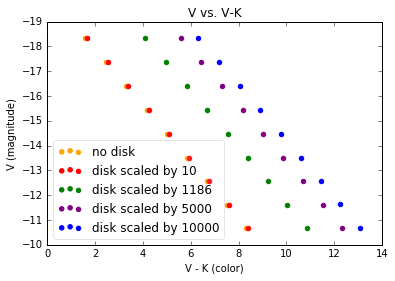

In [69]:
#run plotting function with a temperature
#10 data points (applied extinction law 10 times with integer multiples of A_lambda)
PlotExtinctions('5700',10,0,'orange',"no disk") #no second blackbody
PlotExtinctions('5700',10,10,'red',"disk scaled by 10") #second blackbody scaled by 10
PlotExtinctions('5700',10,1186,'green',"disk scaled by 1186") #properly scaled
PlotExtinctions('5700',10,5000, 'purple',"disk scaled by 5000")
PlotExtinctions('5700',10,10000,'blue',"disk scaled by 10000") #scaled by 10000

plt.legend(loc='lower left',fancybox=True, framealpha=0.1)
plt.gca().invert_yaxis()
plt.xlabel("V - K (color)")
plt.ylabel("V (magnitude)")
plt.title('V vs. V-K')

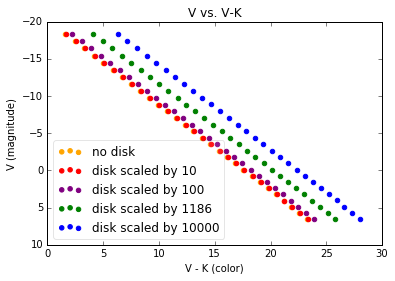

In [79]:
#run plotting function with a temperature
#30 data points
PlotExtinctions('5700',30,0,'orange',"no disk") #no second blackbody
PlotExtinctions('5700',30,10,'red',"disk scaled by 10") #scaled by 10
PlotExtinctions('5700',30,100,'purple',"disk scaled by 100")
PlotExtinctions('5700',30,1186,'green',"disk scaled by 1186") #properly scaled
PlotExtinctions('5700',30,10000,'blue',"disk scaled by 10000") #scaled by 10000

plt.legend(loc='lower left',fancybox=True, framealpha=0.1)
plt.gca().invert_yaxis()
plt.xlabel("V - K (color)")
plt.ylabel("V (magnitude)")
plt.title('V vs. V-K')

### Plotting Slope

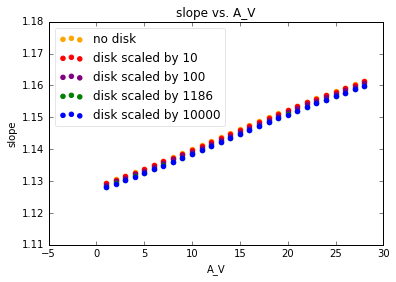

In [97]:
PlotSlopes('5700',30,0,'orange',"no disk",'slope') #no second blackbody
PlotSlopes('5700',30,10,'red',"disk scaled by 10",'slope') #scaled by 10
PlotSlopes('5700',30,100,'purple',"disk scaled by 100",'slope')
PlotSlopes('5700',30,1186,'green',"disk scaled by 1186",'slope') #properly scaled
PlotSlopes('5700',30,10000,'blue',"disk scaled by 10000",'slope') #scaled by 10000

plt.xlabel("A_V")
plt.ylabel("slope")
plt.title('slope vs. A_V')
plt.legend(loc='upper left',fancybox=True, framealpha=0.1)
axes = plt.gca()
#axes.set_ylim(0.,0.002)
#axes.set_xlim([0.5,2.5])

(1.126, 1.138)

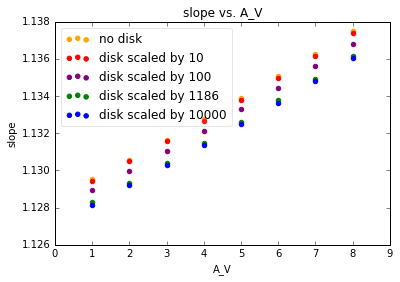

In [101]:
PlotSlopes('5700',10,0,'orange',"no disk",'slope') #no second blackbody
PlotSlopes('5700',10,10,'red',"disk scaled by 10",'slope') #scaled by 10
PlotSlopes('5700',10,100,'purple',"disk scaled by 100",'slope')
PlotSlopes('5700',10,1186,'green',"disk scaled by 1186",'slope') #properly scaled
PlotSlopes('5700',10,10000,'blue',"disk scaled by 10000",'slope') #scaled by 10000

plt.xlabel("A_V")
plt.ylabel("slope")
plt.title('slope vs. A_V')
plt.legend(loc='upper left',fancybox=True, framealpha=0.1)
axes = plt.gca()
axes.set_ylim(1.126,1.138)
#axes.set_xlim([0.5,2.5])

### Plotting Change in Slope

(0.0, 0.002)

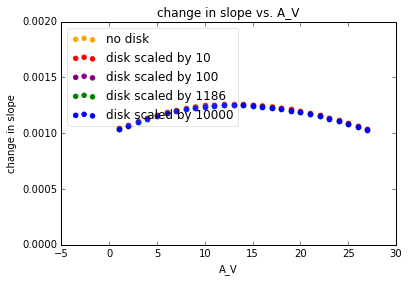

In [90]:
PlotSlopes('5700',30,0,'orange',"no disk",'deltaslope') #no second blackbody
PlotSlopes('5700',30,10,'red',"disk scaled by 10",'deltaslope') #scaled by 10
PlotSlopes('5700',30,100,'purple',"disk scaled by 100",'deltaslope')
PlotSlopes('5700',30,1186,'green',"disk scaled by 1186",'deltaslope') #properly scaled
PlotSlopes('5700',30,10000,'blue',"disk scaled by 10000",'deltaslope') #scaled by 10000

plt.xlabel("A_V")
plt.ylabel("change in slope")
plt.title('change in slope vs. A_V')
plt.legend(loc='upper left',fancybox=True, framealpha=0.1)
axes = plt.gca()
axes.set_ylim(0.,0.002)
#axes.set_xlim([0.5,2.5])

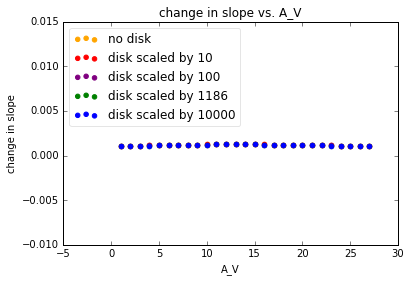

In [91]:
PlotSlopes('5700',30,0,'orange',"no disk",'deltaslope') #no second blackbody
PlotSlopes('5700',30,10,'red',"disk scaled by 10",'deltaslope') #scaled by 10
PlotSlopes('5700',30,100,'purple',"disk scaled by 100",'deltaslope')
PlotSlopes('5700',30,1186,'green',"disk scaled by 1186",'deltaslope') #properly scaled
PlotSlopes('5700',30,10000,'blue',"disk scaled by 10000",'deltaslope') #scaled by 10000

plt.xlabel("A_V")
plt.ylabel("change in slope")
plt.title('change in slope vs. A_V')
plt.legend(loc='upper left',fancybox=True, framealpha=0.1)
axes = plt.gca()
#axes.set_ylim(0.,0.002)
#axes.set_xlim([0.5,2.5])

### Color-Color Plot

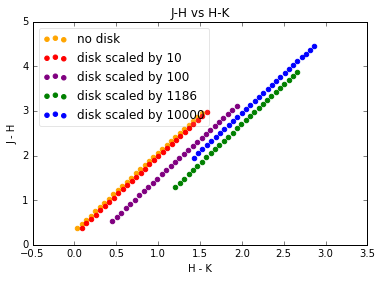

In [63]:
PlotColors('5700',30,0,'orange',"no disk") #no second blackbody
PlotColors('5700',30,10,'red',"disk scaled by 10") #scaled by 10
PlotColors('5700',30,100,'purple',"disk scaled by 100")
PlotColors('5700',30,1186,'green',"disk scaled by 1186") #properly scaled
PlotColors('5700',30,10000,'blue',"disk scaled by 10000") #scaled by 10000

plt.xlabel("H - K")
plt.ylabel("J - H")
plt.title('J-H vs H-K')
plt.legend(loc='upper left',fancybox=True, framealpha=0.1)